In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
dir_csv = '../input/rsna-intracranial-hemorrhage-detection'
dir_train_img = "/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images"
dir_test_img = "/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_test_images"

In [3]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import seaborn as sns

In [4]:
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
#from albumentations import Compose, ShiftScaleRotate, Resize
#from albumentations.pytorch import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from PIL import Image 

from sklearn.metrics import accuracy_score

from time import time
from datetime import timedelta

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np

import pydicom

In [5]:
from os.path import isfile

def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image


class IntracranialDataset(Dataset):

    def __init__(self, csv_file, path, labels, hu_min_value, hu_max_value, augment=False, transform=None):
        
        self.path = path
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = labels
        self.hu_min_value = hu_min_value
        self.hu_max_value = hu_max_value
        self.augment = augment
    
    #################
    
#     def __init__(self, hu_min_value, hu_max_value, augment=False):

#         self.hu_min_value = hu_min_value
#         self.hu_max_value = hu_max_value
#         self.augment = augment
     
    #################

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, idx):
        # from path save each image 
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.dcm')
        
        if not isfile(img_name):
            raise RuntimeError("No.")
        
        #convert image from dicom to pixel array then from array to PIL image 
        image = pydicom.dcmread(img_name).pixel_array.astype('f4')
#         image = (image - image.min()) / (image.max() - image.min())
#         image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image)

#         if img.shape != (512,512):
#             raise RuntimeError("Oh No!", img_name, img.shape)
            
        if self.transform:       
            
            #augmented = self.transform(img)
            #img = augmented['image']   
            image = self.transform(image)
            
        if self.labels:
            
            labels = torch.tensor(
                self.data.loc[idx, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']])
            
            #return {'image': img, 'labels': labels}
            #return img[None,...], labels    
            return image, labels    
        
        else:
            #return {'image': img}
            return image
        
        
    # 2. We need to rescale the pixelarray to Hounsfield units
    #    and we need to focus on our custom window:
    def get_hounsfield_window(self, dataset, min_value, max_value):
        try:
            hu_image = rescale_pixelarray(dataset)
            windowed_image = set_manual_window(hu_image, min_value, max_value)
        except ValueError:
            # set to level 
            windowed_image = min_value * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
        return windowed_image
        
    
    # 3. Resize the image to the input shape of our CNN
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image
    
    # 4. If we like to augment our image, let's do it:
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            #iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5
    

In [6]:
train = pd.read_csv(os.path.join(dir_csv, 'stage_1_train.csv'))
#test = pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))

In [7]:
train.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [8]:
train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head()

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [9]:
# from os.path import isdir
# from os import walk, listdir

# listdir("/kaggle/input/rsna-intracranial-hemorrhage-detection")
# listdir(dir_test_img)

In [10]:
#locating and removing bad images 

dcm = glob.glob(os.path.join(dir_train_img, '*.dcm'))
dcm = [os.path.basename(dcm)[:-4] for dcm in dcm]
dcm = np.array(dcm)

train = train[train['Image'].isin(dcm)]
train.to_csv('train.csv', index=False)

In [11]:
# df_sample = train.sample(n=50000, frac=None, replace=False, weights=None, random_state=None, axis=None)
df_sample = train.loc[:500]
df_sample.to_csv('df_sample', index = False)

In [12]:
type(train)

pandas.core.frame.DataFrame

In [13]:
# Also prepare the test data
# test[['ID','Image','Diagnosis']] = test['ID'].str.split('_', expand=True)
# test['Image'] = 'ID_' + test['Image']
# test = test[['Image', 'Label']]
# test.drop_duplicates(inplace=True)

# test.to_csv('test.csv', index=False)

In [14]:
# def rescale_pixelarray(dataset):
#     image = dataset.pixel_array
#     rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
#     rescaled_image[rescaled_image < -1024] = -1024
#     return rescaled_image

# def set_manual_window(hu_image, min_value, max_value):
#     hu_image[hu_image < min_value] = min_value
#     hu_image[hu_image > max_value] = min_value #max_value
#     return hu_image

# class Preprocessor:    
    
#     def __init__(self, path, hu_min_value, hu_max_value, augment=False):
#         self.path = path
#         self.hu_min_value = hu_min_value
#         self.hu_max_value = hu_max_value
#         self.augment = augment
        
    
#     # 2. We need to rescale the pixelarray to Hounsfield units
#     #    and we need to focus on our custom window:
#     def get_hounsfield_window(self, dataset, min_value, max_value):
#         try:
#             hu_image = rescale_pixelarray(dataset)
#             windowed_image = set_manual_window(hu_image, min_value, max_value)
#         except ValueError:
#             # set to level 
#             windowed_image = min_value * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
#         return windowed_image
        
    
#     # 3. Resize the image to the input shape of our CNN
#     def resize(self, image):
#         image = resize(image, self.nn_input_shape)
#         return image
    
#     # 4. If we like to augment our image, let's do it:
#     def augment_img(self, image): 
#         augment_img = iaa.Sequential([
#             #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
#             #iaa.Affine(rotate=(-10, 10)),
#             iaa.Fliplr(0.5)])
#         image_aug = augment_img.augment_image(image)
#         return image_aug
    
#     def fill_channels(self, image):
#         filled_image = np.stack((image,)*3, axis=-1)
#         return filled_image
    
#     def preprocess(self, identifier):
#         filename = identifier +  ".dcm"
#         dataset = self.load_dicom_dataset(filename)
#         windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
#         image = self.resize(windowed_image)
#         if self.augment:
#             image = self.augment_img(image)
#         image = self.fill_channels(image)
#         return image
    
#     def normalize(self, image):
#         return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5

In [15]:


transform_train = transforms.Compose([
     transforms.Resize((512, 512), interpolation=2),
 #    transforms.RandomHorizontalFlip(),
 #    transforms.RandomCrop(32,padding=4),
     transforms.ToTensor(),
 #   transforms.Normalize((0.5,), (0.5,))
    
])

transform_test= transforms.Compose([
    transforms.Resize((512, 512), interpolation=2),
    transforms.ToTensor(),
  #  transforms.Normalize((0.5,), (0.5,))
    
    
])


#csv_file, path, labels, hu_min_value, hu_max_value, augment=False, transform=None

training_dataset = IntracranialDataset(
    csv_file='df_sample', path=dir_train_img, labels=True, hu_min_value = 0, hu_max_value = 90, augment=False, transform=transform_train)

# test_dataset = IntracranialDataset(
#     csv_file='test.csv', path=dir_test_img, transform=transform_test, labels=False)

# setting up data for train test split 

"""Note it may be important to come back later and balance the 
  dataset so that all image types are represented equally within 
  the train test split"""

train_size = int(len(training_dataset) * 0.8)
test_size = len(training_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_size, test_size)) 

#Create a loder for the training set
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=16, shuffle=False, num_workers=4)

# Create a loder for the test set, note that both shuffle is set to false for the test loader
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [16]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class SimpleNet(nn.Module):
    def __init__(self,num_classes=6):
        super(SimpleNet,self).__init__()
        
        #Create layers of the unit with max pooling in between
        
        self.unit1 = Unit(in_channels=1,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
#       self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
#       self.unit5 = Unit(in_channels=64, out_channels=64)
#       self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
#       self.unit9 = Unit(in_channels=128, out_channels=128)
#       self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
#       self.unit13 = Unit(in_channels=128, out_channels=128)
#       self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
#         Add all the units into the Sequential layer in exact order

#         Original nn with out lost layers 

#         self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
#                                  ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
#                                  self.unit12, self.unit13, self.unit14, self.avgpool)
        
        self.net = nn.Sequential(self.unit1, self.unit2, self.pool1, self.unit4 ,self.unit7, self.pool2, self.unit8, 
                                  self.unit11, self.pool3,
                                  self.unit12, self.avgpool)
        

#       Combination of Sequential(takes list of modules and applies them sequentially) and linear(applies linear transformation to incoming data) 
#       
        self.fc = nn.Sequential(nn.Linear(in_features=128 * 16 * 16,out_features=num_classes) )

# creation of forward propagation   
    def forward(self, input):
        output = self.net(input)
        output = output.view(-1, 128 * 16 * 16)
        output = self.fc(output)
        return output

In [17]:
#       Adjusts the learning rate by a factor of .1 every 30 steps

def adjust_learning_rate(epoch, factor = 0.1, step = 30):
    if (epoch % step) == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] = param_group["lr"] * factor

In [18]:
     creates a def to save model at specific epochs
def save_models(epoch):
    torch.save(model.state_dict(), "cifar10model_{:03d}.model".format(epoch))
    print("Chekcpoint saved")

SyntaxError: invalid syntax (<ipython-input-18-34d74a182c74>, line 1)

In [19]:
from torch.optim import Adam


# Check if gpu support is available
cuda_avail = torch.cuda.is_available()

# Create model, optimizer and loss function
model = SimpleNet(num_classes=6)

#if cuda is available, move the model to the GPU
if cuda_avail:
    model.cuda()

#Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.BCEWithLogitsLoss()

In [20]:
test_qc = 100

def test():
    model.eval()
    test_acc = 0.0
    test_time = time()
    for i, (images, labels) in enumerate(test_loader):

        labels = labels.float()
        
        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        
        test_acc = accuracy_score(np.argmax(outputs.detach().cpu().numpy(), axis = 1), np.argmax(labels.detach().cpu().numpy(), axis = 1), normalize = False)

        if (i % test_qc) == 0 and i > 0:
            print("Test Batch {:3d} of {:3d} [{:6.2f} %], Time: {}".format(
                i+1, len(test_loader), (i+1) / len(test_loader) * 100., timedelta(seconds = np.round((time() - test_time)))))

    test_acc /= len(test_dataset)

    return test_acc

In [21]:
print_qc = 100
testing_iter = 5
saving_iter = 10

def train(num_epochs):
    master_time = time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time()
        please_save = False
        
        model.train()
        
        train_loss = 0.
        train_acc = 0.
        
        print("{:s} Epoch {:3d}/{:3d} {:s}".format("="*15, epoch + 1, num_epochs, "="*15))
        for i, (images, labels) in enumerate(train_loader):
            
            labels = labels.float()

            # Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            # Clear all accumulated gradients
            optimizer.zero_grad()
            # Predict classes using images from the test set
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs, labels)
            
            # Backpropagate the loss
            optimizer.zero_grad()
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            batch_loss = loss.cpu().item() * images.shape[0]
            batch_acc = accuracy_score(np.argmax(outputs.detach().cpu().numpy(), axis = 1), np.argmax(labels.detach().cpu().numpy(), axis = 1), normalize = False)
            
            train_loss += batch_loss
            train_acc += batch_acc
            
            if (i % print_qc) == 0 and i > 0:
                print("Batch {:6d} of {:6d} [{:6.2f} %], Time: {} Train Accuracy: {:7.3f} % , Train Loss: {:10.4e}".format(
                                                        i+1, len(train_loader), (i+1) / len(train_loader) * 100., 
                                                        timedelta(seconds = np.round((time() - start_time))),
                                                        batch_acc / images.shape[0] * 100., batch_loss / images.shape[0]))
        
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        
        if (epoch % testing_iter) == 0:
            test_acc = test()
            
        print("Epoch {:3d} of {:3d}, Time: {} Loss: {:10.4e}, Accuracy (current): {:7.3f} %, Accuracy (test): {:7.3f} %, Accuracy (best) {:7.3f} %".format(
            epoch + 1, num_epochs, timedelta(seconds = np.round(time() - start_time)), train_loss, train_acc * 100., test_acc * 100., best_acc * 100.))
        
        # Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        if test_acc > best_acc:
            please_save = True
            best_acc = test_acc
            
        if (epoch % saving_iter) == 0:
            please_save = True
            
        if (time() - master_time) > 14400:
            please_save = True
            master_time = time()

        # Save the model if the test acc is greater than our current best
        if please_save and epoch > 0:
            save_models(epoch)


In [22]:
%%time

if __name__ == "__main__":
     train(1)

=============== Epoch   1/  1 ===============
Epoch   1 of   1, Time: 0:11:40 Loss: 3.5535e-01, Accuracy (current):   0.250 %, Accuracy (test):   0.000 %, Accuracy (best)   0.000 %
CPU times: user 15min 51s, sys: 6min 25s, total: 22min 17s
Wall time: 11min 39s


In [23]:
training_dataset[1]

(tensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]]]),
 tensor([0, 0, 0, 0, 0, 0]))

In [24]:
training_dataset_images = IntracranialDataset(csv_file='df_sample', path=dir_train_img, labels=True, hu_min_value = 0, hu_max_value = 90)

In [25]:
def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        ''''
        image = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm')).pixel_array
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')'''''
        
        data = pydicom.read_file(os.path.join(dir_train_img,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
        
    plt.suptitle(title)
    plt.show()

In [26]:
train_images = [f for f in listdir(dir_train_img) if isfile(join(dir_train_img, f))]


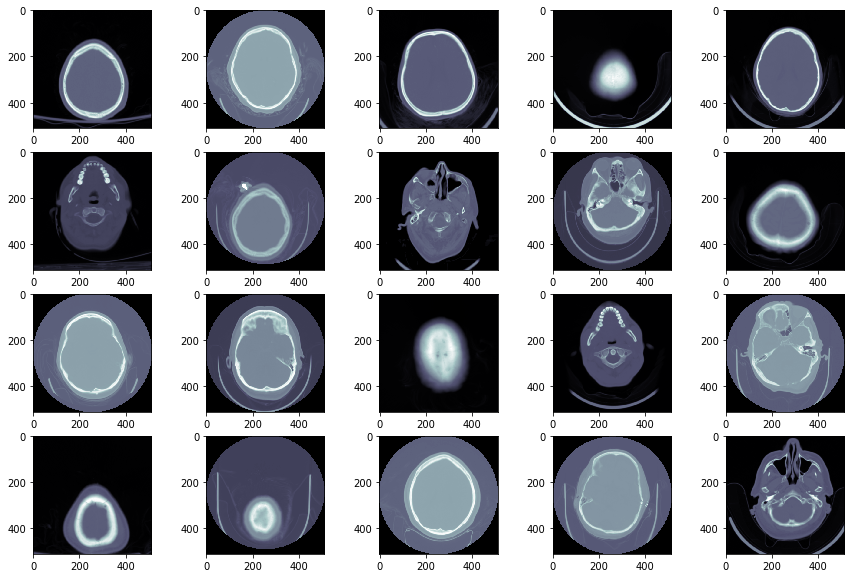

In [27]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(dir_train_img + '/' + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

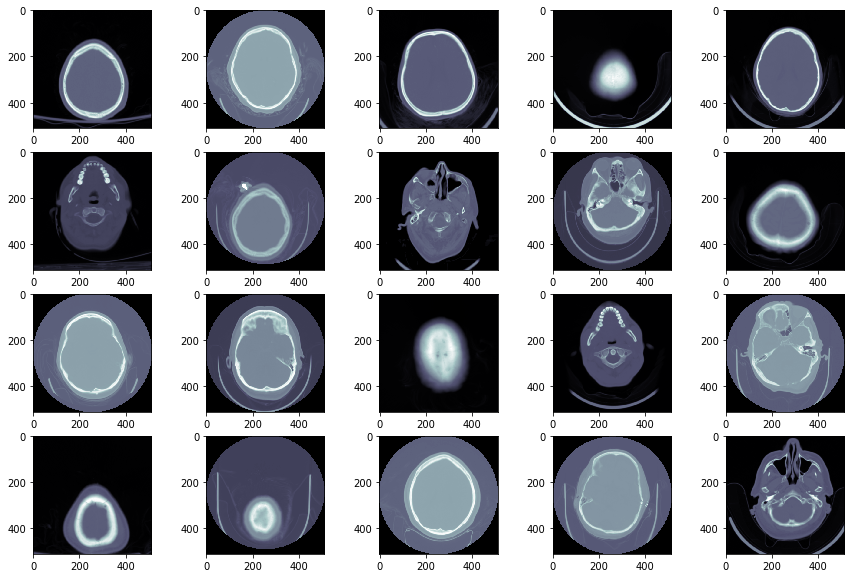

In [28]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(dir_train_img + '/' + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

### Windowing, also known as grey-level mapping, contrast stretching, histogram modification or contrast enhancement is the process in which the CT image greyscale component of an image is manipulated via the CT numbers; doing this will change the appearance of the picture to highlight particular structures. 

### The brightness of the image is, adjusted via the window level. The contrast is adjusted via the window width.

Important Values
* head and neck
* brain W:80 L:40
* subdural W:130-300 L:50-100
* stroke W:8 L:32 or W:40 L:40 3
* temporal bones W:2800 L:600
* soft tissues: W:350–400 L:20–60 4

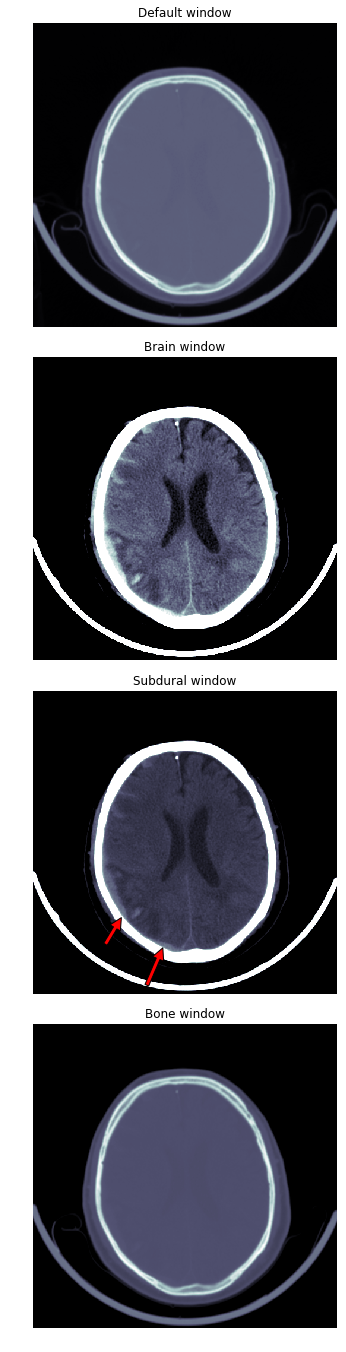

/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_9d9cc6b01.dcm


In [29]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img



def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

    
    
def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(TRAIN_IMG_PATH,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

###ID_6ef1c9a94 good subdural

case = os.path.join(dir_train_img,'ID_9d9cc6b01.dcm')

data = pydicom.read_file(case)

#print(data)

window_center , window_width, intercept, slope = get_windowing(data)
img = pydicom.read_file(case).pixel_array

#displaying the image

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex='col', figsize=(10,24), gridspec_kw={'hspace': 0.1, 'wspace': 0})

ax1.set_title('Default window')
im1 = ax1.imshow(img,  cmap=plt.cm.bone)

ax2.set_title('Brain window')
img2 = window_image(img, 40, 80, intercept, slope)
im2 = ax2.imshow(img2, cmap=plt.cm.bone)

ax3.set_title('Subdural window')
img3 = window_image(img, 80, 200, intercept, slope)
im3 = ax3.imshow(img3, cmap=plt.cm.bone)

ax3.annotate('', xy=(150, 380), xytext=(120, 430),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
ax3.annotate('', xy=(220, 430), xytext=(190, 500),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )

ax4.set_title('Bone window')
img4 = window_image(img, 600, 2800, intercept, slope)
im4 = plt.imshow(img4, cmap=plt.cm.bone)

for ax in fig.axes:
    ax.axis("off")
    
plt.show()
print(case)